In [1]:
import os
from os.path import join as oj
import sys, time
sys.path.insert(1, oj(sys.path[0], '..'))  # insert parent path
import seaborn as sns
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import pmlb
from tqdm import tqdm
from copy import deepcopy
import pickle as pkl
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import cross_validate
import pandas as pd
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")
%matplotlib inline
%load_ext autoreload
%autoreload 2

# look at all dsets

In [172]:
ddir = 'iaip_data/Datasets'
fnames = sorted([fname for fname in os.listdir(ddir) 
                 if 'csv' in fname
                 and not 'formats' in fname
                 and not 'form6' in fname]) # remove outcome
feature_names = [fname[:-4].replace('form', '').replace('-', '_') for fname in fnames]
# demographics = pd.read_csv('iaip_data/Datasets/demographics.csv')
# print(fnames)

In [ ]:
r = {}
for fname in tqdm(fnames):
    df = pd.read_csv(oj(ddir, fname), engine='python')
    df.rename(columns={'SubjectID': 'id'}, inplace=True)
    df.rename(columns={'subjectid': 'id'}, inplace=True)
    assert('id' in df.keys())
    r[fname] = df

In [80]:
num_patients = np.unique(r[fnames[0]]['id'].values).size
missing_arr = np.zeros((len(fnames), num_patients + 1), dtype=np.bool)

for i, fname in enumerate(fnames):
    df = r[fname]
    ids = np.unique(df.id.values)
#     print(np.min(ids), np.max(ids))
    missing_arr[i, ids] = 1

In [ ]:
plt.figure(figsize=(5, 10))
sns.barplot(x=missing_arr.sum(axis=1), y=fnames, orient='h')
plt.xlabel('number of patients')
plt.savefig('num_patients.png')
plt.show()

<Figure size 3600x6000 with 0 Axes>

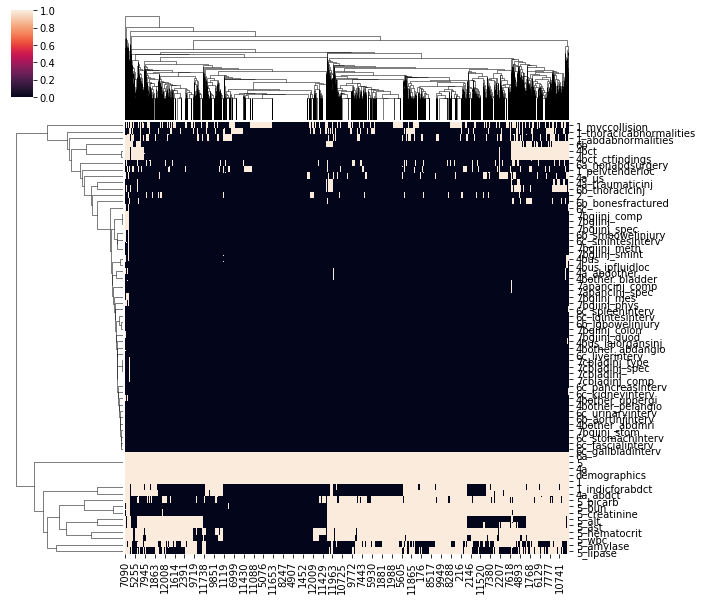

In [107]:
# plt.imshow(not_missing)
plt.figure(figsize=(12, 20), dpi=300)
sns.clustermap(missing_arr, yticklabels=feature_names)
# plt.tight_layout()
plt.savefig('missing.png')
plt.show()

# make features 

**merge everything**

In [ ]:
df = r[fnames[0]]
how = 'outer'
print(len(fnames))
for i, fname in tqdm(enumerate(fnames[1:])):
    df2 = r[fname].copy()
    rename_dict = {
        key: key + '_' + feature_names[i + 1][:8] 
        for key in df2.keys()
        if not key == 'id'
    }
    df2.rename(columns=rename_dict, inplace=True)
    df = pd.merge(df, df2, on='id', how=how)
df.to_pickle('features.pkl')

**code features**

In [161]:
# for k in ['RACE', 'SEX']:
#     df[k] = df[k].astype(str)
for k in ['ageinyrs']:
    df[k] = df[k].astype(float)

In [ ]:
# import pandas_profiling
# df.profile_report(style={'full_width':True})

In [176]:
df.keys()

Index(['id', 'repeat_instance', 'BladInjType', 'BladExLac', 'BladExLacLoc',
       'BladIntLac'],
      dtype='object')

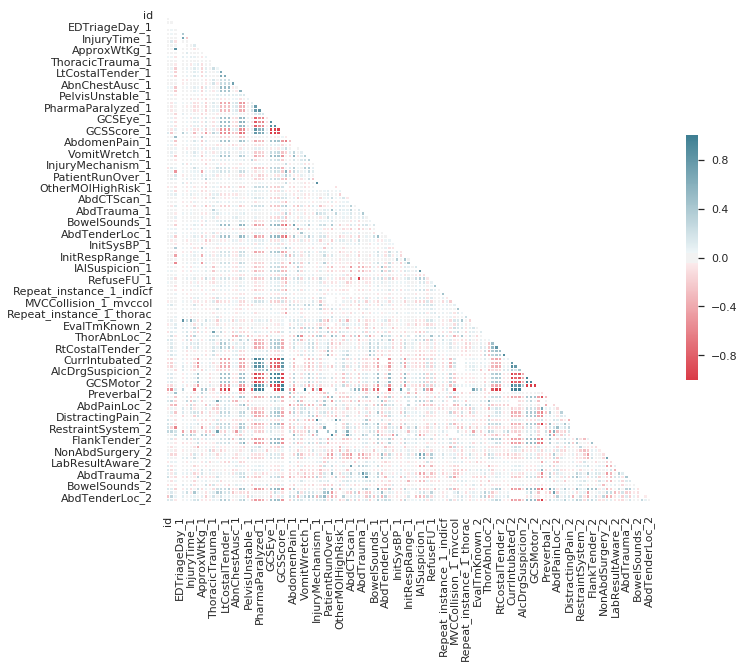

In [170]:
# Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
# sns.clustermap(corr) #, mask=mask, cmap=cmap, vmax=.3, center=0,
#             square=True, linewidths=.5, cbar_kws={"shrink": .5})

***outcome***

In [189]:
outcomes_full_surg = pd.read_csv('iaip_data/Datasets/form6c.csv')
outcome_serious = pd.DataFrame({
    'id': outcomes_full_surg.subjectid,
    'outcome_surge': np.ones(outcomes_full_surg.subjectid.size)
})

# Intra-abdominal injury diagnosed in the ED/during hospitalization by any diagnostic method
# 1 is yes
# 2 is no -> remap to 0
outcomes_full_pi = pd.read_csv('iaip_data/Datasets/form6b.csv').rename(columns={'SubjectID': 'id'}) #, inplace=True)
print(outcomes_full_pi.keys())
# outcomes_full_pi['id'] = outcomes_full_pi['SubjectID'] 
idxs = outcomes_full_pi['IAIinED1'] == 2
outcomes_full_pi.loc[idxs, 'IAIinED1'] = 0
outcomes = outcomes_full_pi[['id', 'IAIinED1']]

Index(['id', 'IAIinED1', 'Liver', 'CTGrade', 'Spleen', 'CTGrade2', 'Kidney',
       'CTGrade3', 'GITract', 'Mesenteric', 'SmallBowel', 'LargeBowel',
       'Pancreas', 'Gallbladder', 'FascialInjury', 'AdrenalGland',
       'UrinaryBladder', 'VascularStruct', 'HemoperitFluid', 'OtherChecked',
       'TOrgansOther', 'BldTransfusion', 'IVFluids', 'ThoracicInjury1',
       'Thoracotomy', 'PelvicFracture1', 'SurgicalRepair', 'Other1'],
      dtype='object')


In [190]:
outcomes_full_pi

,id,IAIinED1,Liver,CTGrade,Spleen,CTGrade2,Kidney,CTGrade3,GITract,Mesenteric,...,HemoperitFluid,OtherChecked,TOrgansOther,BldTransfusion,IVFluids,ThoracicInjury1,Thoracotomy,PelvicFracture1,SurgicalRepair,Other1
0,8,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,2.0,2,NaN,NaN
1,10,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,2.0,2,NaN,NaN
2,33,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,2.0,2,NaN,NaN
3,41,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,2.0,1,2.0,NaN
4,49,1,2.0,NaN,2.0,NaN,1.0,4.0,2.0,NaN,...,2.0,2.0,NaN,1.0,1.0,1,2.0,2,NaN,NaN
5,50,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,2.0,2,NaN,NaN
6,55,1,1.0,3.0,2.0,NaN,2.0,NaN,2.0,NaN,...,1.0,2.0,NaN,4.0,NaN,2,NaN,2,NaN,NaN
7,56,1,2.0,NaN,2.0,NaN,2.0,NaN,2.0,NaN,...,2.0,2.0,NaN,4.0,2.0,2,NaN,2,NaN,NaN
8,57,1,2.0,NaN,2.0,NaN,2.0,NaN,1.0,1.0,...,1.0,2.0,NaN,4.0,1.0,1,2.0,2,NaN,NaN
9,60,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1,2.0,1,1.0,NaN
